# Chapter 1 - Graph Theory

## Requirements

This notebook was tested on Linux and MacOS, using a conda environment.

Details to build the conda environment can be found here: https://github.com/ftheberge/GraphMiningNotebooks

In case users would find some issues with the notebook, we ask the users to open an issue in the GitHub repository.

For the data, make sure you have the correct directory in next cell.

In [1]:
## setting the path to the datasets
datadir='../Datasets/'


In [2]:
## required packages for this Chapter
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf


## Summary

In this notebook, we look at basic statistics such as:
- degree distribution
- clustering coefficient
- shortest path lengths

The main lesson is that even with such simple measures, we can identify huge difference between different types of graphs, namely:

- social-type graphs (GitHub developers)
- transportation-type (power grid) network.

## GitHub Developers Graph

#### Description

A large undirected social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. 

The graph has two types of nodes: 
- web developer 
- machine learning developer 

Below, we construct this graph (with igraph); later we will look at subgraphs respectively for web or ml developer.

The graph is stored in object ```gh```; look at the code below to see how we can also store attributes for edges and vertices in such igraph objects.

There are several ways to read the edges; here we used a function from the ```pandas``` package.

In [3]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]


### node attrbutes

Below we show the attributes (data frame X) for the first few nodes.
The 'id' is from the list of edges while the 'Rank' correspond to the node ordering in the graph 'gh'.
Finally 'ml_target' is a binary flag indicating ml developer (if equal 1) or web developer (if zero).

In [4]:
X.head()

,id,name,ml_target,Rank
0,0,Eiryyy,0,0
23977,23977,airtoxin,0,1
1,1,shawflying,0,2
34526,34526,ghosind,0,3
2370,2370,jasondu,0,4


### GitHub subgraphs

We build the two subgraphs below: ml and web developers.

In [5]:
## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())


GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


Note that some ml developers are connected only to web developers and vice-versa. 

Therefore, some nodes will end up with no connection (degree 0) in the subgraphs.


In [6]:
## github graph: count ml with connection to web only and vice-versa
c_ml = c_web = 0
for v in gh.vs():
    if v['lbl']=='ml':
        if set([gh.vs[i]['lbl'] for i in gh.neighbors(v)])=={'web'}:
            c_ml+=1
    else:
        if set([gh.vs[i]['lbl'] for i in gh.neighbors(v)])=={'ml'}:
            c_web+=1
print(c_ml,'ml dev. connected only to web dev. and',c_web,'web dev. connected only to ml dev.')        

2308 ml dev. connected only to web dev. and 285 web dev. connected only to ml dev.


In [7]:
## this should correpond to the number of degree 0 nodes
print(sum([i==0 for i in gh_ml.degree()]))
print(sum([i==0 for i in gh_web.degree()]))


2308
285


## Europe Electric Grid

Network of high voltage grid in Europe. Vertices are stations and edges are the lines connecting them.
More details at: https://zenodo.org/record/47317#.Xt6nzy3MxTY

The graph is stored in object ```gr```; look at the code below to see how we can also store attributes for edges and vertices in such igraph objects. 

Edges have directionality, but for this notebook, we consider an undirected version of this graph, so after reading the edges, we "simplify" the graph to remove multiedges.

Nodes have different attributes, including longitude and latitude; we use those to force a graph layout for plotting according to the geography.

There are also several types of nodes: 'joint', 'merge', 'plant', 'station', 'sub_station', 'substation'.

In [8]:
## read edge list for the grid network and build undirected graph
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()] ## tuples with lat/lon
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

In [9]:
## here is an example of a node along with its attributes
gr.vs[0]

igraph.Vertex(<igraph.Graph object at 0x118087850>, 0, {'name': '43193', 'longitude': 7.61602141237887, 'latitude': 47.2325986006218, 'type': 'substation', 'layout': (7.61602141237887, 47.2325986006218), 'size': 3, 'color': 'black'})

# Graph Features

Below, we compute several basic features for the 4 graphs we have:
- GitHub
- GitHub (ml developers subgraph)
- GitHub (web developers subgraph)
- Grid

Please refer to the book for details of those features.

Note that running the cell below can take a few minutes.


In [10]:
## compute and store basic stats in a table
## this can take a few minutes
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.connected_components().membership)+1,
            G.connected_components().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['GitHub'] + baseStats(gh))
S.append(['GitHub (ml)'] + baseStats(gh_ml))
S.append(['GitHub (web)'] + baseStats(gh_web))
S.append(['Grid'] + baseStats(gr))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

,0,1,2,3
graph,GitHub,GitHub (ml),GitHub (web),Grid
nodes,37700,9739,27961,13844
edges,289003,19684,224623,17277
$d_{min}$,1,0,0,1
$d_{mean}$,15.331724,4.042304,16.066879,2.495955
$d_{median}$,6.0,2.0,6.0,2.0
$d_{quant_{99}}$,138.01,39.0,145.0,8.0
$d_{max}$,9458,482,8194,16
diameter,11,13,9,147
components,1,2466,297,59


#### Analysis of the results

What do we see in the table above?

First, look at the degree distribution; the GitHub graphs have a wide range of values, including some very high degree nodes, while the Grid graph has degree in range 1 to 16 only.

The diameter (max shortest path length) is also quite different; it is common for social networks to have relatively small diameter. On the other hand, geometric graphs by nature must have large diameter.

Looking at components, the GitHub graph is connected (single component), but the two subgraphs are not, and there are event nodes with null degree as we already saw. The Grid graph has several components, but most nodes fall is what we call the "giant component".

Finally, we see some differences between the local and global clustering coefficients for the GitHub graphs; why is this so? what happens with very high degree nodes?

In [11]:
## Note: to produce LaTeX code from a DataFrame:
#  df = D.round(decimals=3)
#  print(df.to_latex(index=True))

## Visualize part of the Grid network

For the Grid graph, we select a range of lat/lon that correspond to the Iberic peninsula.



1562 nodes


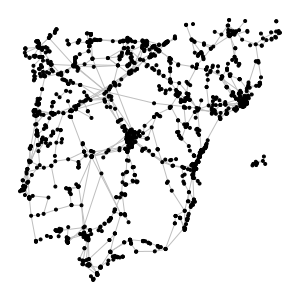

In [12]:
## subgraph of Grid -- Iberic peninsula
V = [v for v in gr.vs() if v['latitude']>36 and v['latitude']<44 and v['longitude']>-10 and v['longitude']<4]
gr_spain = gr.subgraph(V)
ly = ig.Layout(gr_spain.vs['layout'])
ly.mirror(1)
print(gr_spain.vcount(),'nodes')
#ig.plot(gr_spain, 'grid_sg.eps', layout=ly, bbox=(0,0,300,300))
ig.plot(gr_spain, layout=ly, bbox=(0,0,300,300))


## Visualize part of the GitHub (ml) graph

There is no lat/lon here; in the code below, we take the giant component for the GitHub ml subgraph,
and arbitrary cut w.r.t. the computed layout to display a portion of the subgraph.

This is for illustration only; note that this is quite different from the Grid graph, with clumps (dense areas) and less regular edge distribution.


showing 454 nodes


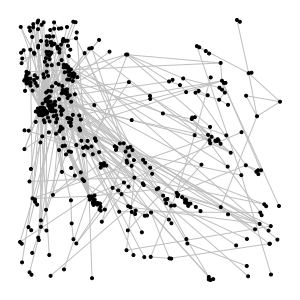

In [13]:
## plot subgraph for github(ml)
sg = gh_ml.connected_components().giant()
ly = sg.layout_auto()
sg.vs['x'] = [x[0] for x in ly]
sg.vs['y'] = [x[1] for x in ly]

## 
z = 40 ## adjust to zoom in or out
V = [v for v in sg.vs() if v['x']<z and v['x']>-z and v['y']<z and v['y']>-z]
ssg = sg.subgraph(V).connected_components().giant()
ssg.vs['size'] = 3
print('showing',ssg.vcount(),'nodes')
#ig.plot(ssg, 'github_ml_sg.eps',bbox=(0,0,300,300))
ig.plot(ssg,bbox=(0,0,300,300))

## Visualize part of the GitHub (web) graph

Same as above for the larger GitHub web subgraph; 
Uncomment the cell below to run. Note that this can be slow!


## Compare degree distributions

We plot the (empirical) cumulative distribution functions (cdf) of the degree distribution for the GitHib and Grid graphs. 

As we notes before, for the GitHub graph, most nodes have low degree, but a few have very high degree, up to almost 10,000. This is not the case with the Grid graph: almost all nodes having degree less than 10, and max degree observed is only 16.


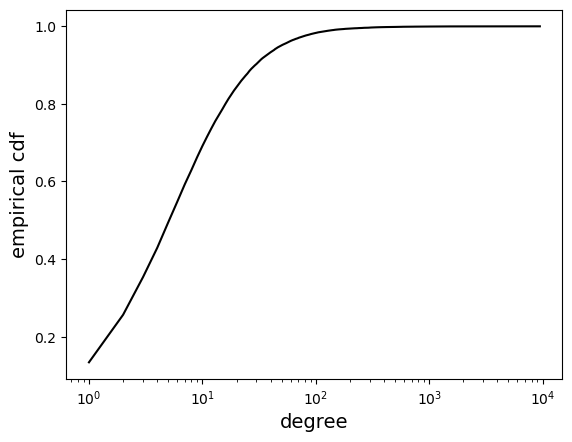

In [14]:
## degree distribution - GitHub graph
deg = gh.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='black',label='GitHub')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gh.eps');


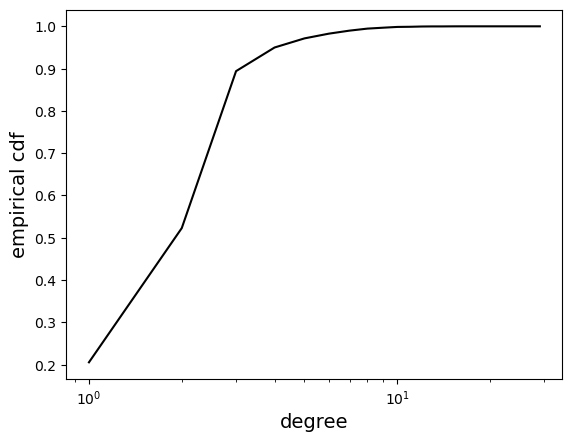

In [15]:
## degree distribution - Grid graph
## we see much lower degree here
deg = gr.degree()
e = ecdf(deg)
x = np.arange(1,30,1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='black',label='Grid')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gr.eps');


## Shortest paths distribution

In the plots below, we consider 100 randomly chosen nodes, and compute the length of the shortest path to reach every other node. We then plot histograms of those values.

Once again we see much different distributions; for the GitHub graph, most paths are quite short, with common values in the range from 2 to 6.
For the Grid graph however, the paths are generally longer, and over a much wider range.


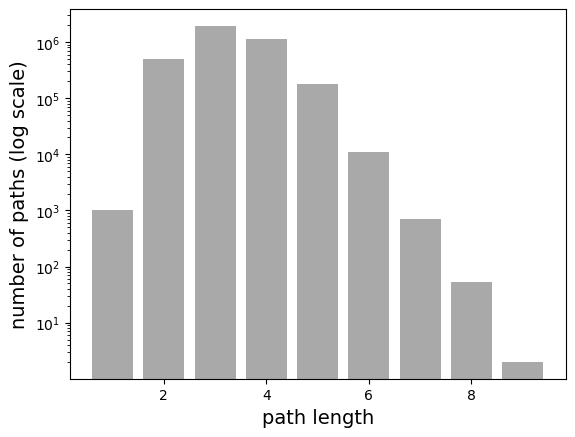

In [16]:
## shortest paths length from a given node, GitHub graph
from collections import Counter
sg = gh.connected_components().giant()
V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample
sp = []
for v in V:
    sp.extend(sg.distances(source=v)[0])
c = Counter(sp)
s = sorted(c.items())

fig, ax = plt.subplots()
## exclude 0-length paths
x = [x[0] for x in s[1:]]
y = [x[1] for x in s[1:]]
b = ax.bar(x, y, color='darkgrey') 

ax.set_yscale('log')

ax.set_xlabel('path length',fontsize=14)
ax.set_ylabel('number of paths (log scale)',fontsize=14);
#plt.savefig('pathlen_github.eps');


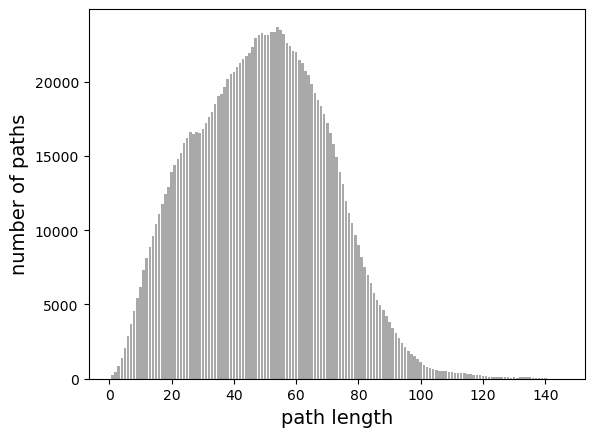

In [17]:
## min path length from that node to other nodes, Grid network
sg = gr.connected_components().giant()
V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample
sp = []
for v in V:
    sp.extend(sg.distances(source=v)[0])
c = Counter(sp)
s = sorted(c.items())

fig, ax = plt.subplots()
## exclude 0-length paths
x = [x[0] for x in s[1:]]
y = [x[1] for x in s[1:]]
b = ax.bar(x, y, color='darkgrey') 
ax.set_xlabel('path length',fontsize=14)
ax.set_ylabel('number of paths',fontsize=14);
#plt.savefig('pathlen_grid.eps');


## Local clustering coefficient

Below, we compare the average local clustering coefficients as a function
of the node degrees. We consider degrees from 10 to 1000.

Looking at a log-log plot, we see a power law relation between those quantities; 
we also compute the regression line for comparison.

In [18]:
## build dataframe with degrees and local clustering coefficients
## and compute mean values w.r.t. degree.
## GitHub graph
mindeg = 10
maxdeg = 1000
D = pd.DataFrame(np.array([gh.transitivity_local_undirected(),gh.degree()]).transpose(),
            columns=['CC','d'])
C = D[D['d']>=mindeg].groupby(by='d').mean()
deg = list(C.index)
l = sum([i<=maxdeg for i in deg])
deg = deg[:l]
clust = list(C['CC'])[:l]


power law exponent: -0.7159837009746673


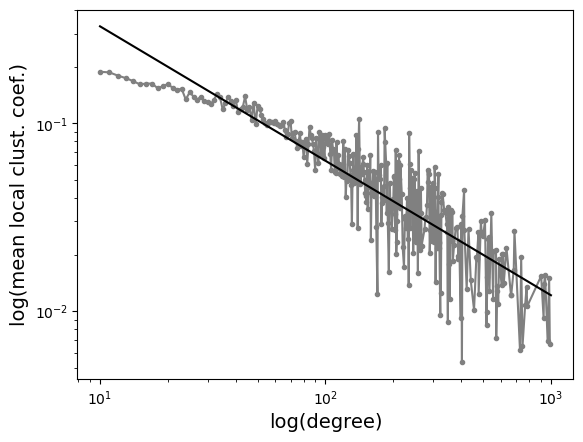

In [19]:
# Fit a regression (log-log scale) and plot
regressor = LinearRegression()  
x = [np.log(i) for i in deg]
y = [np.log(i) for i in clust]
regressor.fit(np.array(x).reshape(-1,1), y)
print('power law exponent:',regressor.coef_[0])

## plot on log-log scale
b = regressor.intercept_
a = regressor.coef_[0]
plt.loglog(deg,clust,'.-',color='grey')

## since log y = a log x + b, y = e^b x^a, we plot:
plt.plot([mindeg,maxdeg],[np.exp(b)*mindeg**a,np.exp(b)*maxdeg**a],color='black')
plt.xlabel('log(degree)',fontsize=14)
plt.ylabel('log(mean local clust. coef.)',fontsize=14);

## un-comment to save plot in a file
#plt.savefig('localCC.eps');